In [72]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume

import experiments.utils as utils

In [73]:
RESULTS_DIR = Path("prescriptors/nsga2/training_runs/eds-no-rhea")
FIGURE_DIR = Path("experiments/figures/eds")
OUTCOMES = ["ELUC", "change"]

In [74]:
def plot_gens(ax: plt.Axes, results_dir: Path, gens: list[int], total_gens: int, outcomes: list[str]):
    """
    Plots the pareto front for multiple generations.
    :param results_dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = utils.pareto.get_gens_df(results_dir, gens, pareto=True)
    merged_df = merged_df.sort_values(by=outcomes[0])
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        curve = merged_df[merged_df["gen"] == gen]
        curve = curve.sort_values(by=outcomes[1])
        ax.plot(curve[outcomes[1]], curve[outcomes[0]], color=colors[i], label= "Gen " + str(gen), marker="o", markersize=3)

    overall_pareto_df = utils.pareto.get_overall_pareto_df(total_gens, results_dir, outcomes)

    overall_pareto_df = overall_pareto_df.sort_values(by=outcomes[1])
    ax.plot(overall_pareto_df[outcomes[1]], overall_pareto_df[outcomes[0]], color="r", label="Final Pareto Front", marker="o", markersize=3)
    ax.set_xlabel(outcomes[1] if outcomes[1] != "change" else "Change")
    ax.set_ylabel(outcomes[0])
    ax.legend()
    ax.set_title("a) Evolution of the Pareto Front")
    return ax

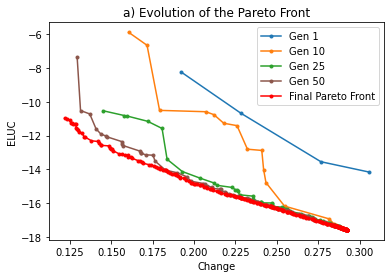

In [75]:
fig, ax = plt.subplots()
ax = plot_gens(ax, RESULTS_DIR, [1, 10, 25, 50], 100, OUTCOMES)
plt.show()

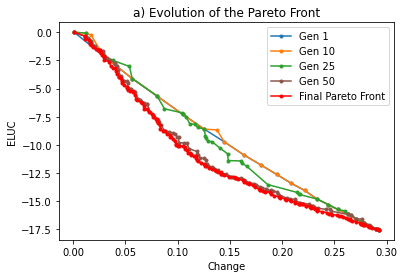

In [76]:
fig, ax = plt.subplots()
ax = plot_gens(ax, Path("prescriptors/nsga2/training_runs/eds-rhea"), [1, 10, 25, 50], 100, OUTCOMES)
plt.show()

In [77]:
def plot_all_gens(ax: plt.Axes, gens: list, outcomes: list[str], results_dir: Path):
    all_gens_df = utils.pareto.get_gens_df(results_dir, gens)
    ax.scatter(all_gens_df[outcomes[1]], all_gens_df[outcomes[0]], s=3, label="All Prescriptors Evaluated")

    # Plot last gen's pareto front in red
    overall_pareto = utils.pareto.get_overall_pareto_df(gens[-1], results_dir, outcomes)
    ax.scatter(overall_pareto[outcomes[1]], y=overall_pareto[outcomes[0]], c='red', label="Final Pareto Front", s=3)
    ax.set_xlabel(outcomes[1] if outcomes[1] != "change" else "Change")
    ax.set_ylabel(outcomes[0])
    ax.legend(loc="upper left")
    ax.set_title("b) Performance of All Evaluated Prescriptors")
    return ax

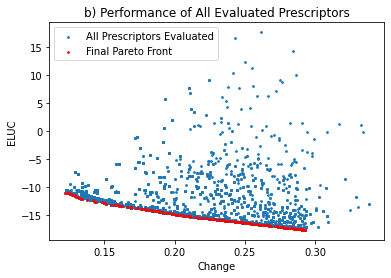

In [78]:
fig, ax = plt.subplots()
ax = plot_all_gens(ax, list(range(1, 101)), OUTCOMES, RESULTS_DIR)
plt.show()

In [79]:
def plot_hypervolume(outcomes: list[str],
                     results_dir: Path,
                     total_gens: int,
                     ref_point: np.ndarray,
                     ideal: np.ndarray):
    """
    Plots the hypervolume of our experiment.
    For the worst possible point we use -1 * the ideal eluc seed, and the 2 max changes from the seeds.
    For the best possible point we use the ideal eluc seed with 0 change.
    """
    nadir = ref_point
    metric = Hypervolume(ref_point=ref_point,
                         norm_ref_point=True,
                         zero_to_one=True,
                         ideal=ideal,
                         nadir=nadir)
    hypervolumes = []
    for gen in range(1, total_gens+1):
        results_df = pd.read_csv(results_dir / f"{gen}.csv")
        F = results_df[outcomes].values
        hypervolumes.append(metric.do(F))


    plt.plot(range(1, total_gens+1), hypervolumes)
    plt.xlabel("Generation")
    plt.ylabel("Hypervolume")
    plt.title("Hypervolume Over Time")
    plt.show()

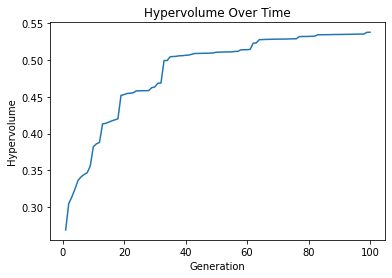

In [80]:
ref_point = np.array([17.375717, 0.29098859373497826, 0.07468234])[:len(OUTCOMES)]
ideal = np.array([-17.375717, 0, 0])[:len(OUTCOMES)]
plot_hypervolume(OUTCOMES, RESULTS_DIR, 100, ref_point, ideal)

### RHEA

### Paper Figures

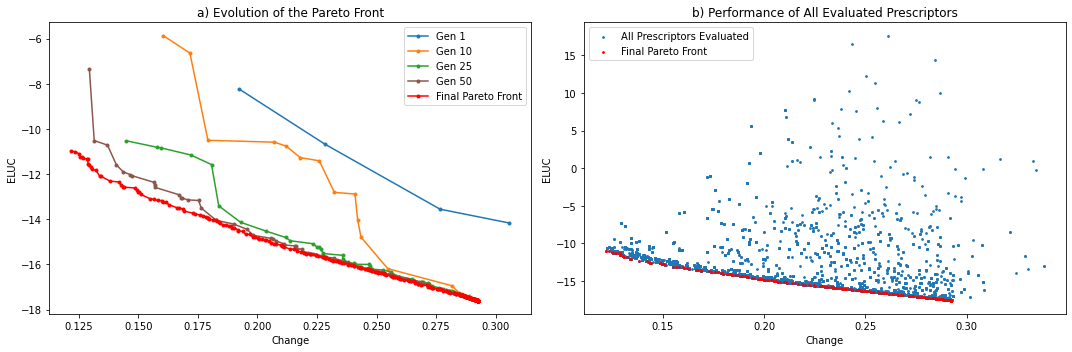

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
axes[0] = plot_gens(axes[0], RESULTS_DIR, [1, 10, 25, 50], 100, OUTCOMES)
axes[1] = plot_all_gens(axes[1], list(range(1, 101)), OUTCOMES, RESULTS_DIR)
# plt.savefig(FIGURE_DIR / "pareto-fig.png", dpi=300, format="png")
plt.show()